#### Hartree-Fock in Pytorch

In [3]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/usdb.nat'


SPS=SingleParticleState(file_name=file_name)

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:55<00:00,  2.33s/it]


In [4]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

In [5]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [-3.45589442e-19]
dimension= 640


Hartree-Fock method

In [6]:
model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)



In [7]:

optimizer = optim.Adam(model.parameters(), lr=0.1)

num_steps = 200
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -12.858080
Step   20 | Energy = -27.609497
Step   40 | Energy = -30.568672
Step   60 | Energy = -35.905540
Step   80 | Energy = -37.139397
Step  100 | Energy = -37.167561
Step  120 | Energy = -37.183060
Step  140 | Energy = -37.183556
Step  160 | Energy = -37.183777
Step  180 | Energy = -37.183781
Step  199 | Energy = -37.183788


In [8]:
def slater_determinants(C, fock_basis):
    # C: [M, N]
    # fock_basis: [F, M]
    F = fock_basis.shape[0]
    N = C.shape[1]
    psi = torch.zeros(F, dtype=C.dtype)

    for i in range(F):
        occ = fock_basis[i]   # [M] boolean
        occ_indices = torch.nonzero(occ).squeeze()              # [N, N] rows of occupied orbitals
        C_sub = C[occ_indices, :]            # [N, N]
        psi[i] = torch.det(C_sub)     # compute Slater determinant amplitude

    return psi  # [F] amplitudes over Fock basis




In [9]:
psi_hf=slater_determinants(model.C,torch.tensor(NSMHamiltonian.basis))
psi_hf=psi_hf.detach().numpy()
print(psi_hf.shape)
psi_hf=psi_hf/np.linalg.norm(psi_hf)



(640,)


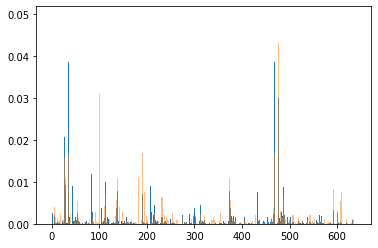

-39.714357127950294
fidelity= 0.6421327945070867


In [10]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [11]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C))

True


#### Sample Based Diagonalization HF and exact Gs

In [21]:
n_instances=9000

In [15]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]

ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],10)
errors_sdg_gs=[]
energies_sdg_gs=[]
for n_instances in ns_instances: 
        selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                # for a,idx_a in enumerate(selection):
                #     for b,idx_b in enumerate(selection):
                #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]


        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        errors_sdg_gs.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
        energies_sdg_gs.append(effective_egs[0])
        print(effective_egs)


[-29.0334]
[-30.83858684]
[-30.8653733]
[-30.78749345]
[-31.51270011]
[-32.96759606]
[-32.77357376]
[-32.61199166]
[-34.21738125]
[-34.80127951]
[-34.71754033]
[-35.21611687]
[-35.76546226]
[-35.94588133]
[-36.34742282]
[-36.65488971]
[-37.45065942]
[-37.34449913]
[-37.6437502]
[-37.8672981]
[-38.40746667]
[-38.31737289]
[-38.63500358]
[-38.93912537]
[-38.90501317]
[-39.256127]
[-39.35629424]
[-39.58812824]
[-39.55351624]
[-39.88630289]
[-39.88356144]
[-40.20454903]
[-40.30576413]
[-40.33479969]
[-40.49029516]
[-40.35838666]
[-40.50913914]
[-40.74835284]
[-40.73596856]
[-40.88414072]
[-40.92644485]
[-40.93513752]
[-40.99006557]
[-41.043993]
[-41.08827156]
[-41.13333184]
[-41.15922938]
[-41.20077239]
[-41.24381709]
[-41.28623093]
[-41.2904689]
[-41.32301225]
[-41.33034813]
[-41.34638085]
[-41.36371416]
[-41.3717642]
[-41.37854127]
[-41.38840235]
[-41.3934777]
[-41.39566772]
[-41.39628935]
[-41.39649007]
[-41.39649007]
[-41.39649007]


In [16]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf=[]
energies_sdg_hf=[]
for n_instances in ns_instances: 
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                # for a,idx_a in enumerate(selection):
                #     for b,idx_b in enumerate(selection):
                #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]


        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        errors_sdg_hf.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
        energies_sdg_hf.append(effective_egs[0])
        print(effective_egs)


[-24.6051]
[-30.39376828]
[-30.68689705]
[-31.80214231]
[-32.48037624]
[-32.51705499]
[-33.17787499]
[-33.90571723]
[-34.1372676]
[-34.52768201]
[-34.44147096]
[-35.49843078]
[-35.8938222]
[-36.10387822]
[-36.03966353]
[-36.24150822]
[-36.55782175]
[-37.01288179]
[-37.07344107]
[-37.73719903]
[-37.52757373]
[-37.53548881]
[-37.88337993]
[-37.87080334]
[-38.07009975]
[-38.53787913]
[-38.48149055]
[-38.96237879]
[-38.8379783]
[-39.04123839]
[-39.204175]
[-39.32683702]
[-39.29647953]
[-39.38979167]
[-39.67908788]
[-39.5638127]
[-39.64676459]
[-39.73433558]
[-39.88278738]
[-40.11692661]
[-40.12806667]
[-40.22107287]
[-40.21309725]
[-40.28187459]
[-40.33861428]
[-40.45780857]
[-40.47895168]
[-40.52307701]
[-40.46021209]
[-40.62436723]
[-40.6446645]
[-40.6946748]
[-40.8215735]
[-40.84134828]
[-40.83296174]
[-40.89997139]
[-40.95959851]
[-40.90471493]
[-40.99450902]
[-41.08346661]
[-41.23865012]
[-41.22948483]
[-41.30841714]
[-41.39236976]


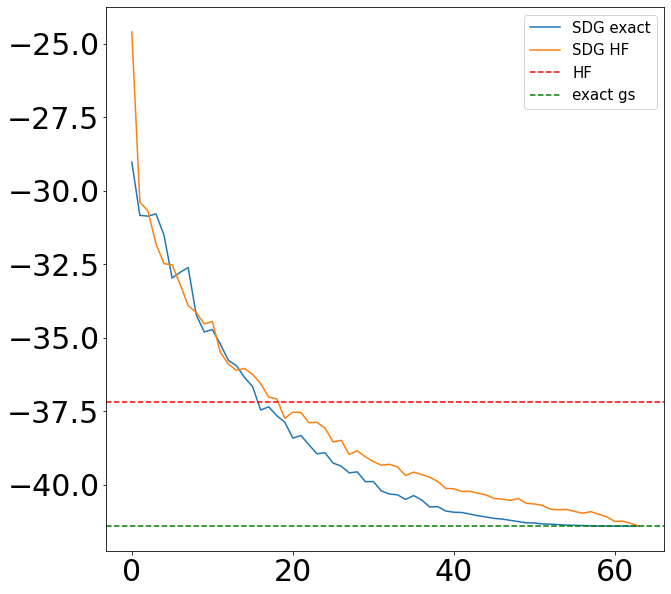

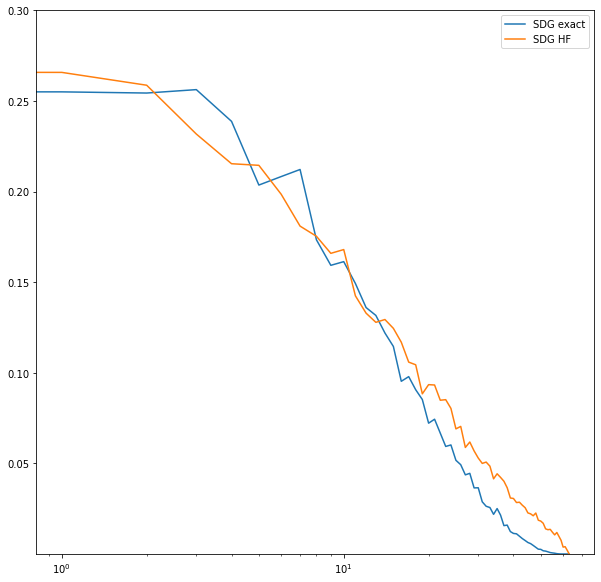

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(energies_sdg_gs,label='SDG exact')
plt.plot(energies_sdg_hf,label='SDG HF')
plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0](0.99),color='green',linestyle='--',label='exact gs')

plt.legend(fontsize=15)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)


plt.figure(figsize=(10,10))
plt.plot(np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.ylim([10**-6,0.3])
plt.semilogx()
plt.legend()
plt.show()